<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/rnn_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPool1D, Embedding
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.0.0


In [2]:
# download example data
!wget https://lazyprogrammer.me/course_files/spam.csv

--2019-12-16 07:57:43--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:30::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2019-12-16 07:57:43 (10.7 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# load in the data
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# rename columns to something better
df.columns = ["labels", "data"]
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# create binary labels
df["b_labels"] = df["labels"].map({"ham": 0, "spam": 1})
Y = df["b_labels"].values

In [0]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df["data"], Y, test_size=0.33)

In [8]:
# tokenize & index the sentences
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens")

Found 7245 unique tokens


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print(f"shape of data train tensor: {data_train.shape}")

# get sequence length
T = data_train.shape[1]

shape of data train tensor: (3733, 162)


In [10]:
# pad test sequences
data_test = pad_sequences(sequences_test, maxlen=T)
print(f"shape of data test tensor: {data_test.shape}")

shape of data test tensor: (1839, 162)


In [11]:
# create the model

# choose embedding dimensionality
D = 20

# hidden state dimensionality
M = 15

# to get V x D sized embedding metrix, V + 1 should be passed
# because index starts from 1. (0 for padding)
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 162, 20)           144920    
_________________________________________________________________
lstm (LSTM)                  (None, 162, 15)           2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 147,096
Trainable params: 147,096
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train the model
r = model.fit(data_train, Ytrain, epochs=10, validation_data=(data_test, Ytest))

Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 11s 3ms/sample - loss: 0.4783 - accuracy: 0.8615 - val_loss: 0.3780 - val_accuracy: 0.8749
Epoch 2/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.4011 - accuracy: 0.8615 - val_loss: 0.3706 - val_accuracy: 0.8749
Epoch 3/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.3720 - accuracy: 0.8615 - val_loss: 0.3346 - val_accuracy: 0.8749
Epoch 4/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.3390 - accuracy: 0.8615 - val_loss: 0.3044 - val_accuracy: 0.8749
Epoch 5/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.2964 - accuracy: 0.8615 - val_loss: 0.2551 - val_accuracy: 0.8749
Epoch 6/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.2310 - accuracy: 0.8615 - val_loss: 0.1961 - val_accuracy: 0.8749
Epoch 7/10
3733/3733 [==============================] - 4s 1ms/sample - los

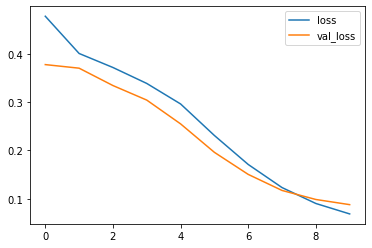

In [13]:
# plot the loss
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

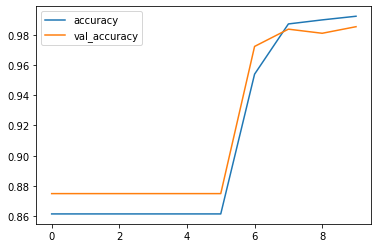

In [14]:
# plot the accuracy
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()